<a href="https://colab.research.google.com/github/Bo-Ni/ProtBert_Notebook_set_0/blob/main/2_FGF_FGFR_classification_Revi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FGF and FGFR classificaiton using ProtBert
## dataset source: Sabrina 
## Code: Bo Ni @ cambridge, Apr 2022

In [1]:
# debug or cluster run
IF_Google = 1
IF_Debug = 1


In [2]:
# prepare the backages for the environment
import os
import sys

In [3]:
if IF_Google == 1:
  print(os.popen('nvidia-smi').read())

Thu Apr 14 06:11:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# 1. transformers

if IF_Google == 1:
  try:
    import transformers
  except ImportError as e:
    print(os.popen('pip install transformers').read())

In [5]:
# 2. accelerate

if IF_Google == 1:
  try:
    import accelerate
  except ImportError as e:
    print(os.popen('pip install accelerate').read())

In [6]:
# 3. datasets (for metrics)

if IF_Google == 1:
  try:
    import datasets
  except ImportError as e:
    print(os.popen('pip install datasets').read())

In [7]:
# 4. load in the packages
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
#
if IF_Google!=1:
  import matplotlib 
  matplotlib.use('Agg')
#
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import re

import pickle

import datasets

In [8]:
from transformers import AutoTokenizer, AutoModel
from accelerate import Accelerator
# import accelerate

In [9]:

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [10]:
# 5. test some packages

accelerator = Accelerator(mixed_precision='fp16')
device = accelerator.device

In [11]:
if IF_Debug==1:
  print(device)

cuda


In [12]:
# UnSolved: this one works in google colab, 
# but not in the cluster. 
# To avoid this, 
# the source code, "accelerator.py": Line 481
# is modified. 
# dict: /home/bo_ni/ondemand/group_data/bo_ni/HomeVirEnvi/0_Pytorch/lib/python3.9/site-packages/accelerate
# if self.native_amp and self.state.use_fp16:
# >>  if self.native_amp and (self.state.mixed_precision=='fp16'):
if IF_Google == 1:
  print(accelerator.state.use_fp16)
  print()
  print(accelerator.state)

True

Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: fp16



In [13]:

# 6. introduce the pretrained model
model_name = 'Rostlab/prot_bert_bfd'

In [14]:
# 7. paths in the image
if IF_Google == 1:
  DB_path_inImag = './'
  Working_Path_inImag = './'
else:
  # for singularity image
  DB_path_inImag = '/Share_Data/'
  Working_Path_inImag = '/data/'
  # for virtual environment case: set these from the .sh file
  DB_path_inImag = str( sys.argv[1] )
  Working_Path_inImag = str( sys.argv[2] )

In [15]:
# for cluster
# ref: https://stackoverflow.com/questions/62691279/how-to-disable-tokenizers-parallelism-true-false-warning
if IF_Google != 1:
  os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [16]:
# 8. download the necessary files for google
if IF_Google == 1:
  file_exists = os.path.exists('./homemade_metric_classification_accuracy/homemade_metric_classification_accuracy.py')
  if not (file_exists):
    # download files
    print(os.popen('wget https://www.dropbox.com/s/p5otp5pwapltx9c/fgf_fgfr_Revi_test.csv').read())
    print(os.popen('wget https://www.dropbox.com/s/t2ke3eu27m498gq/fgf_fgfr_Revi_trai.csv').read())
    print(os.popen('wget https://www.dropbox.com/s/5jv9fu45lxv86aa/fgf_fgfr_Revi_vali.csv').read())

    print(os.popen('wget https://www.dropbox.com/s/gbegysaiby8lc0t/fgf_fgfr_UnRe_test.csv').read())
    print(os.popen('wget https://www.dropbox.com/s/oxgy6c84yftl57f/fgf_fgfr_UnRe_trai.csv').read())
    print(os.popen('wget https://www.dropbox.com/s/msrn0hqfm56mveh/fgf_fgfr_UnRe_vali.csv').read())

    print(os.popen('wget https://www.dropbox.com/s/lc99jlhq6sbntxq/homemade_metric_classification_accuracy.py').read())
    # move the file
    print(os.popen('mkdir homemade_metric_classification_accuracy').read())
    print(os.popen('mv homemade_metric_classification_accuracy.py ./homemade_metric_classification_accuracy').read())


## 1. Loading the data

In [17]:
metric_trai = datasets.load_metric(DB_path_inImag+'homemade_metric_classification_accuracy')
metric_vali = datasets.load_metric(DB_path_inImag+'homemade_metric_classification_accuracy')
metric_test = datasets.load_metric(DB_path_inImag+'homemade_metric_classification_accuracy')

# # df_trai_full = pd.read_csv(DB_path_inImag+'Freq_Posi_sub_Training.csv')
# the small dataset: reviewed
df_trai = pd.read_csv(DB_path_inImag+'fgf_fgfr_Revi_trai.csv')
df_vali = pd.read_csv(DB_path_inImag+'fgf_fgfr_Revi_vali.csv')
df_test = pd.read_csv(DB_path_inImag+'fgf_fgfr_Revi_test.csv')
# # the large one: unreviewd
# df_trai = pd.read_csv(DB_path_inImag+'fgf_fgfr_UnRe_trai.csv')
# df_vali = pd.read_csv(DB_path_inImag+'fgf_fgfr_UnRe_vali.csv')
# df_test = pd.read_csv(DB_path_inImag+'fgf_fgfr_UnRe_test.csv')

In [18]:
accelerator.print(df_trai.shape)
accelerator.print(df_vali.shape)
accelerator.print(df_test.shape)

(102, 10)
(22, 10)
(22, 10)


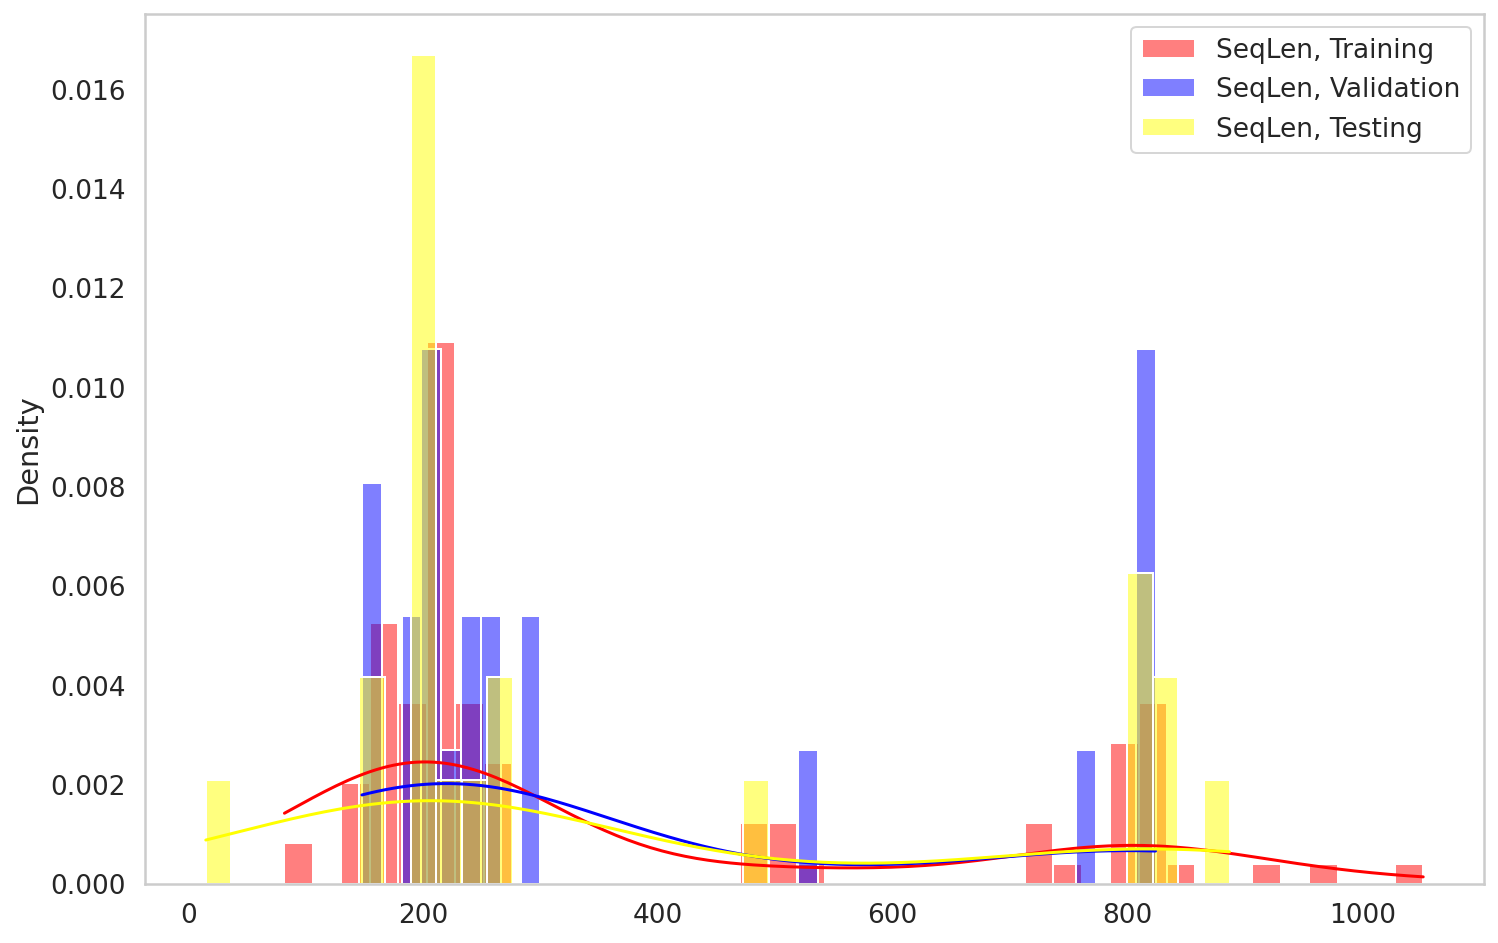

In [19]:
# take a look at the distributions
if accelerator.is_main_process:
  # for seq_len
  plt.figure()
  sns.histplot(df_trai.Length.values, 
              bins=40, kde=True, stat='density', color="red", 
               label="SeqLen, Training");
  sns.histplot(df_vali.Length.values, 
              bins=40, kde=True, stat='density', color="blue", 
               label="SeqLen, Validation");
  sns.histplot(df_test.Length.values, 
              bins=40, kde=True, stat='density', color="yellow", 
               label="SeqLen, Testing");
  # sns.histplot(df_trai.Seq_Len.values, 
  #             bins=40, kde=True, stat='density', color="red", 
  #              label="SeqLen, Training");
  # sns.histplot(df_vali.Seq_Len.values, 
  #             bins=40, kde=True, stat='density', color="blue", 
  #              label="SeqLen, Validation", alpha  = 0.2);
  # sns.histplot(df_test.Seq_Len.values, 
  #             bins=40, kde=True, stat='density', color="yellow", 
  #              label="SeqLen, Testing",alpha  = 0.2);

  plt.grid()
  plt.legend()
  # if IF_Google==1:
  #   plt.show() 
  # plt.savefig(Working_Path_inImag+'Three_Sets_Seq_Len.png')


In [20]:
# Base what we see before, here we choose the sequence length
MAX_LEN = 1800
MAX_LEN = 1500
MAX_LEN = 1000
MAX_LEN = 200


## 2. Loading the model

In [21]:
# 2.1 load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          do_lower_case=False)


In [22]:

# wash the raw sequences
def format_seq_for_datasets(example):
    seq = example["Seq"]
    # on the format
    seq = " ".join("".join(seq.split()))
    # on the uncommon AA
    example["Seq"] = re.sub(r"[UZOB]", "X", seq)
#     # for test
#     example["Seq"] = 'AAA'
    return example

# =============================================
def format_seq_for_dataframe(seq):
    # on the format
    seq1 = " ".join("".join(seq.split()))
    # on the uncommon AA
    seq1 = re.sub(r"[UZOB]", "X", seq1)
#     # for test
#     example["Seq"] = 'AAA'
    return seq1

# ============================================
def to_labels(KnotType):
  if KnotType == '3_1':
    return 1
  elif KnotType == '0_1':
    return 0
  else:
    return -1

In [23]:
df_trai.head(1)

,Entry,Entry name,Gene names,Status,Protein names,Organism,Length,Fragment,Sequence,GForGFR
0,P21658,FGF6_MOUSE,NaN,reviewed,Fibroblast growth factor 6 (FGF-6) (Heparin se...,Mus musculus (Mouse),208,NaN,MALGQRLFITMSRGAGRVQGTLQALVFLGVLVGMVVPSPAGARANG...,0


In [24]:
# update the format of sequences for Bert model
# 
df_trai["Seq"] = df_trai["Sequence"].apply(format_seq_for_dataframe)
df_vali["Seq"] = df_vali["Sequence"].apply(format_seq_for_dataframe)
df_test["Seq"] = df_test["Sequence"].apply(format_seq_for_dataframe)


In [25]:
# 
df_trai["Label"] = df_trai["GForGFR"]# .apply(to_labels)
df_vali["Label"] = df_vali["GForGFR"]# .apply(to_labels)
df_test["Label"] = df_test["GForGFR"]# .apply(to_labels)

In [26]:
if IF_Debug == 1:
  print(df_trai.describe())

            Length     GForGFR       Label
count   102.000000  102.000000  102.000000
mean    366.754902    0.303922    0.303922
std     268.405465    0.462221    0.462221
min      82.000000    0.000000    0.000000
25%     194.000000    0.000000    0.000000
50%     216.000000    0.000000    0.000000
75%     508.000000    1.000000    1.000000
max    1052.000000    1.000000    1.000000


In [27]:
# in debug mode, collect useful info and tests
if IF_Debug == 1:
  sample_seq = df_trai.Seq[1]
  print( sample_seq )


M Y S A P S A C T C L C L H F L L L C F Q V Q V L A A E E N V D F R I H V E N Q T R A R D D V S R K Q L R L Y Q L Y S R T S G K H I Q V L G R R I S A R G E D G D K Y A Q L L V E T D T F G S Q V R I K G K E T E F Y L C M N R K G K L V G K P D G T S K E C V F I E K V L E N N Y T A L M S A K Y S G W Y V G F T K K G R P R K G P K T R E N Q Q D V H F M K R Y P K G Q A E L Q K P F K Y T T V T K R S R R I R P T H P G


In [28]:
if IF_Debug == 1:
  sample_tokens = tokenizer.tokenize(sample_seq)
  print( sample_tokens )
  print( len(sample_tokens) )


['M', 'Y', 'S', 'A', 'P', 'S', 'A', 'C', 'T', 'C', 'L', 'C', 'L', 'H', 'F', 'L', 'L', 'L', 'C', 'F', 'Q', 'V', 'Q', 'V', 'L', 'A', 'A', 'E', 'E', 'N', 'V', 'D', 'F', 'R', 'I', 'H', 'V', 'E', 'N', 'Q', 'T', 'R', 'A', 'R', 'D', 'D', 'V', 'S', 'R', 'K', 'Q', 'L', 'R', 'L', 'Y', 'Q', 'L', 'Y', 'S', 'R', 'T', 'S', 'G', 'K', 'H', 'I', 'Q', 'V', 'L', 'G', 'R', 'R', 'I', 'S', 'A', 'R', 'G', 'E', 'D', 'G', 'D', 'K', 'Y', 'A', 'Q', 'L', 'L', 'V', 'E', 'T', 'D', 'T', 'F', 'G', 'S', 'Q', 'V', 'R', 'I', 'K', 'G', 'K', 'E', 'T', 'E', 'F', 'Y', 'L', 'C', 'M', 'N', 'R', 'K', 'G', 'K', 'L', 'V', 'G', 'K', 'P', 'D', 'G', 'T', 'S', 'K', 'E', 'C', 'V', 'F', 'I', 'E', 'K', 'V', 'L', 'E', 'N', 'N', 'Y', 'T', 'A', 'L', 'M', 'S', 'A', 'K', 'Y', 'S', 'G', 'W', 'Y', 'V', 'G', 'F', 'T', 'K', 'K', 'G', 'R', 'P', 'R', 'K', 'G', 'P', 'K', 'T', 'R', 'E', 'N', 'Q', 'Q', 'D', 'V', 'H', 'F', 'M', 'K', 'R', 'Y', 'P', 'K', 'G', 'Q', 'A', 'E', 'L', 'Q', 'K', 'P', 'F', 'K', 'Y', 'T', 'T', 'V', 'T', 'K', 'R', 'S', 'R', 'R',

In [29]:
if IF_Debug == 1:
  sample_token_ids = tokenizer.convert_tokens_to_ids(sample_tokens)
  print( sample_token_ids )

[21, 20, 10, 6, 16, 10, 6, 23, 15, 23, 5, 23, 5, 22, 19, 5, 5, 5, 23, 19, 18, 8, 18, 8, 5, 6, 6, 9, 9, 17, 8, 14, 19, 13, 11, 22, 8, 9, 17, 18, 15, 13, 6, 13, 14, 14, 8, 10, 13, 12, 18, 5, 13, 5, 20, 18, 5, 20, 10, 13, 15, 10, 7, 12, 22, 11, 18, 8, 5, 7, 13, 13, 11, 10, 6, 13, 7, 9, 14, 7, 14, 12, 20, 6, 18, 5, 5, 8, 9, 15, 14, 15, 19, 7, 10, 18, 8, 13, 11, 12, 7, 12, 9, 15, 9, 19, 20, 5, 23, 21, 17, 13, 12, 7, 12, 5, 8, 7, 12, 16, 14, 7, 15, 10, 12, 9, 23, 8, 19, 11, 9, 12, 8, 5, 9, 17, 17, 20, 15, 6, 5, 21, 10, 6, 12, 20, 10, 7, 24, 20, 8, 7, 19, 15, 12, 12, 7, 13, 16, 13, 12, 7, 16, 12, 15, 13, 9, 17, 18, 18, 14, 8, 22, 19, 21, 12, 13, 20, 16, 12, 7, 18, 6, 9, 5, 18, 12, 16, 19, 12, 20, 15, 15, 8, 15, 12, 13, 10, 13, 13, 11, 13, 16, 15, 22, 16, 7]


In [30]:

if IF_Debug == 1:
  # some special tokens
  # [SEP]: marker for ending of a sentence
  print(tokenizer.sep_token, tokenizer.sep_token_id)
  # [CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification
  print(tokenizer.cls_token, tokenizer.cls_token_id)
  # There is also a special token for padding:
  print(tokenizer.pad_token, tokenizer.pad_token_id)
  # Everything else can be encoded using the [UNK] (unknown) token:
  print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 3
[CLS] 2
[PAD] 0
[UNK] 1


In [31]:
if IF_Debug == 1:
  print( tokenizer.encode_plus(sample_seq) )
  print(len( tokenizer.encode_plus(sample_seq).attention_mask ))

{'input_ids': [2, 21, 20, 10, 6, 16, 10, 6, 23, 15, 23, 5, 23, 5, 22, 19, 5, 5, 5, 23, 19, 18, 8, 18, 8, 5, 6, 6, 9, 9, 17, 8, 14, 19, 13, 11, 22, 8, 9, 17, 18, 15, 13, 6, 13, 14, 14, 8, 10, 13, 12, 18, 5, 13, 5, 20, 18, 5, 20, 10, 13, 15, 10, 7, 12, 22, 11, 18, 8, 5, 7, 13, 13, 11, 10, 6, 13, 7, 9, 14, 7, 14, 12, 20, 6, 18, 5, 5, 8, 9, 15, 14, 15, 19, 7, 10, 18, 8, 13, 11, 12, 7, 12, 9, 15, 9, 19, 20, 5, 23, 21, 17, 13, 12, 7, 12, 5, 8, 7, 12, 16, 14, 7, 15, 10, 12, 9, 23, 8, 19, 11, 9, 12, 8, 5, 9, 17, 17, 20, 15, 6, 5, 21, 10, 6, 12, 20, 10, 7, 24, 20, 8, 7, 19, 15, 12, 12, 7, 13, 16, 13, 12, 7, 16, 12, 15, 13, 9, 17, 18, 18, 14, 8, 22, 19, 21, 12, 13, 20, 16, 12, 7, 18, 6, 9, 5, 18, 12, 16, 19, 12, 20, 15, 15, 8, 15, 12, 13, 10, 13, 13, 11, 13, 16, 15, 22, 16, 7, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [32]:
if IF_Debug == 1:
  sample_encoding = tokenizer.encode_plus(
      sample_seq,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
  )

In [33]:
if IF_Debug == 1:
  print( sample_encoding.keys() )
  print(len(sample_encoding['input_ids'][0])) # show that it is padded
  print(sample_encoding['input_ids'].shape)

dict_keys(['input_ids', 'attention_mask'])
200
torch.Size([1, 200])


In [34]:
if IF_Debug == 1:
  print(sample_encoding['input_ids'][0])
  # inverse the tokenization to have a look at the special tokens:
  print(tokenizer.convert_ids_to_tokens(sample_encoding['input_ids'][0]))

tensor([ 2, 21, 20, 10,  6, 16, 10,  6, 23, 15, 23,  5, 23,  5, 22, 19,  5,  5,
         5, 23, 19, 18,  8, 18,  8,  5,  6,  6,  9,  9, 17,  8, 14, 19, 13, 11,
        22,  8,  9, 17, 18, 15, 13,  6, 13, 14, 14,  8, 10, 13, 12, 18,  5, 13,
         5, 20, 18,  5, 20, 10, 13, 15, 10,  7, 12, 22, 11, 18,  8,  5,  7, 13,
        13, 11, 10,  6, 13,  7,  9, 14,  7, 14, 12, 20,  6, 18,  5,  5,  8,  9,
        15, 14, 15, 19,  7, 10, 18,  8, 13, 11, 12,  7, 12,  9, 15,  9, 19, 20,
         5, 23, 21, 17, 13, 12,  7, 12,  5,  8,  7, 12, 16, 14,  7, 15, 10, 12,
         9, 23,  8, 19, 11,  9, 12,  8,  5,  9, 17, 17, 20, 15,  6,  5, 21, 10,
         6, 12, 20, 10,  7, 24, 20,  8,  7, 19, 15, 12, 12,  7, 13, 16, 13, 12,
         7, 16, 12, 15, 13,  9, 17, 18, 18, 14,  8, 22, 19, 21, 12, 13, 20, 16,
        12,  7, 18,  6,  9,  5, 18, 12, 16, 19, 12, 20, 15, 15,  8, 15, 12, 13,
        10,  3])
['[CLS]', 'M', 'Y', 'S', 'A', 'P', 'S', 'A', 'C', 'T', 'C', 'L', 'C', 'L', 'H', 'F', 'L', 'L', 'L', 'C'

In [35]:
df_vali.head(1)

,Entry,Entry name,Gene names,Status,Protein names,Organism,Length,Fragment,Sequence,GForGFR,Seq,Label
0,P70378,FGF11_MOUSE,NaN,reviewed,Fibroblast growth factor 11 (FGF-11) (Fibrobla...,Mus musculus (Mouse),225,NaN,MAALASSLIRQKREVREPGGSRPVSAQRRVCPRGTKSLCQKQLLIL...,0,M A A L A S S L I R Q K R E V R E P G G S R P ...,0


In [36]:
# We also need to create a couple of data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ProtKnotTypeDataset(
    seq=df.Seq.to_numpy(),
    seq_len=df.Length.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  # ToDo: may need to adjust num_workers
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

# group the results
# We have all building blocks required to create a PyTorch dataset. 
class ProtKnotTypeDataset(Dataset):

  def __init__(self, seq, seq_len, targets, tokenizer, max_len):
    self.seq = seq
    self.seq_len = seq_len
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.seq)
  
  def __getitem__(self, item):
    seq = str(self.seq[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      seq,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      # pad_to_max_length=True,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'protein_seq': seq,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [37]:
# create data loaders
BATCH_SIZE = 16
BATCH_SIZE = 2

trai_data_loader = create_data_loader(df_trai, tokenizer, 
                                      MAX_LEN, BATCH_SIZE)
vali_data_loader = create_data_loader(df_vali, tokenizer, 
                                      MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, 
                                      MAX_LEN, BATCH_SIZE)

In [38]:
accelerator.print(
    '# of batchs in three sets:',
    len(trai_data_loader),len(vali_data_loader),len(test_data_loader)
)

# of batchs in three sets: 51 11 11


In [39]:
# another debug mode to go over batch data and model
if IF_Debug == 1:
  # have a look at an example batch from our training data loader
  one_batch_data = next(iter(trai_data_loader))
  print( one_batch_data.keys() )

dict_keys(['protein_seq', 'input_ids', 'attention_mask', 'targets'])


In [40]:
if IF_Debug == 1:
  # print(one_batch_data['protein_seq'].shape)
  print(one_batch_data['input_ids'].shape)
  print(one_batch_data['attention_mask'].shape)
  print(one_batch_data['targets'].shape)
  # should be [Batch_len, Max_Length]

torch.Size([2, 200])
torch.Size([2, 200])
torch.Size([2])


In [41]:
if IF_Debug==1:
  print(one_batch_data['targets'])

tensor([0, 0])


In [42]:
# use the basic Bert model
# try to find the format of the output of the Bert model
if IF_Debug == 1:
  bert_model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
# test this model on ONE datapoint
if IF_Debug == 1:
  print(sample_encoding.keys())
  print(sample_encoding['input_ids'])
  print(sample_encoding['attention_mask'])
  print(sample_encoding['attention_mask'].shape)

dict_keys(['input_ids', 'attention_mask'])
tensor([[ 2, 21, 20, 10,  6, 16, 10,  6, 23, 15, 23,  5, 23,  5, 22, 19,  5,  5,
          5, 23, 19, 18,  8, 18,  8,  5,  6,  6,  9,  9, 17,  8, 14, 19, 13, 11,
         22,  8,  9, 17, 18, 15, 13,  6, 13, 14, 14,  8, 10, 13, 12, 18,  5, 13,
          5, 20, 18,  5, 20, 10, 13, 15, 10,  7, 12, 22, 11, 18,  8,  5,  7, 13,
         13, 11, 10,  6, 13,  7,  9, 14,  7, 14, 12, 20,  6, 18,  5,  5,  8,  9,
         15, 14, 15, 19,  7, 10, 18,  8, 13, 11, 12,  7, 12,  9, 15,  9, 19, 20,
          5, 23, 21, 17, 13, 12,  7, 12,  5,  8,  7, 12, 16, 14,  7, 15, 10, 12,
          9, 23,  8, 19, 11,  9, 12,  8,  5,  9, 17, 17, 20, 15,  6,  5, 21, 10,
          6, 12, 20, 10,  7, 24, 20,  8,  7, 19, 15, 12, 12,  7, 13, 16, 13, 12,
          7, 16, 12, 15, 13,  9, 17, 18, 18, 14,  8, 22, 19, 21, 12, 13, 20, 16,
         12,  7, 18,  6,  9,  5, 18, 12, 16, 19, 12, 20, 15, 15,  8, 15, 12, 13,
         10,  3]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [44]:
if IF_Debug == 1:
  sample_output = bert_model(
    input_ids=sample_encoding['input_ids'], 
    attention_mask=sample_encoding['attention_mask']
  )

In [45]:
if IF_Debug == 1:
  print( sample_output )
  print()
  # last hidden state: Sequence of hidden-states at the output of the last layer of the model
  print( sample_output.last_hidden_state )
  print()
  print( sample_output.last_hidden_state.shape )

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0447,  0.0038,  0.0906,  ..., -0.0619, -0.0606, -0.0931],
         [ 0.0458,  0.0376,  0.0544,  ...,  0.1041, -0.0927,  0.0470],
         [ 0.0167, -0.0088, -0.0014,  ...,  0.0443,  0.0370, -0.0064],
         ...,
         [-0.0028,  0.0039,  0.0515,  ...,  0.0644, -0.0856, -0.0145],
         [-0.1077,  0.0093,  0.0911,  ...,  0.0634, -0.1193, -0.0489],
         [ 0.0428,  0.0056,  0.0873,  ..., -0.0630, -0.0604, -0.0906]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.3218, -0.2713,  0.3187,  ..., -0.3184, -0.3250,  0.3196]],
       grad_fn=<TanhBackward0>), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)

tensor([[[ 0.0447,  0.0038,  0.0906,  ..., -0.0619, -0.0606, -0.0931],
         [ 0.0458,  0.0376,  0.0544,  ...,  0.1041, -0.0927,  0.0470],
         [ 0.0167, -0.0088, -0.0014,  ...,  0.0443,  0.0370, -0.0064],
         ...,
         [-0.0028,  0.0

In [46]:
# We have the hidden state for each of our 1800 tokens 
# (the length of our example sequence). But why 1024? 
# This is the number of hidden units in the feedforward-networks. 
# We can verify that by checking the config:
if IF_Debug == 1:
  print( bert_model.config.hidden_size )

1024


In [47]:
if IF_Debug == 1:
  # the output of the pretrained model
  # may only used for per-seq predictions
  print( sample_output.pooler_output )
  print()
  print( sample_output.pooler_output.shape )

tensor([[-0.3218, -0.2713,  0.3187,  ..., -0.3184, -0.3250,  0.3196]],
       grad_fn=<TanhBackward0>)

torch.Size([1, 1024])


In [48]:
# use all of this knowledge 
# to create a regresser that uses the BERT model

# one parameter: n_freqs

class ProteinBERTRegresserNonNeg(nn.Module):

  def __init__(self, n_freqs):
    super(ProteinBERTRegresserNonNeg, self).__init__()
    self.bert = BertModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.lin = nn.Linear(self.bert.config.hidden_size, n_freqs)
    # to make a non-negative prediction
    # self.out = nn.functional.relu()
    self.out = nn.ReLU()
  
  def forward(self, input_ids, attention_mask):
#     _, pooled_output = self.bert(
#       input_ids=input_ids,
#       attention_mask=attention_mask
#     )
    result = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = result.pooler_output
    outdrop = self.drop(pooled_output)
    output = self.lin(outdrop)
    return self.out(output)

# without ReLU
class ProteinBERTClassifier(nn.Module):

  def __init__(self, n_class):
    super(ProteinBERTClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.lin = nn.Linear(self.bert.config.hidden_size, n_class)
    # to make a non-negative prediction
    # self.out = nn.functional.relu()
    # self.out = nn.ReLU()
  
  def forward(self, input_ids, attention_mask):
#     _, pooled_output = self.bert(
#       input_ids=input_ids,
#       attention_mask=attention_mask
#     )
    result = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = result.pooler_output
    outdrop = self.drop(pooled_output)
    # output = self.lin(outdrop)
    return self.lin(outdrop)

# Our classifier delegates most of the heavy lifting to the BertModel. 
# We use a dropout layer for some regularization and a fully-connected 
# layer for our output. 
# Note that we're returning the raw output of the last layer since that 
# is required for the cross-entropy loss function in PyTorch to work.

In [49]:
# # of frequences
N_CLASS = 2

In [50]:
# activate the model
model = ProteinBERTClassifier(n_class=N_CLASS)
model = model.to(device)


Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
# test this model on a batch of data
if IF_Debug == 1:
  print( one_batch_data['input_ids'].shape )
  print( one_batch_data['attention_mask'].shape )
  print( one_batch_data )


torch.Size([2, 200])
torch.Size([2, 200])
{'protein_seq': ['M A L G Q R L F I T M S R G A G R V Q G T L Q A L V F L G V L V G M V V P S P A G A R A N G T L L D S R G W G T L L S R S R A G L A G E I S G V N W E S G Y L V G I K R Q R R L Y C N V G I G F H L Q V P P D G R I S G T H E E N P Y S L L E I S T V E R G V V S L F G V K S A L F I A M N S K G R L Y T T P S F H D E C K F R E T L L P N N Y N A Y E S D L Y R G T Y I A L S K Y G R V K R G S K V S P I M T V T H F L P R I', 'M Y S A P S A C T C L C L H F L L L C F Q V Q V L A A E E N V D F R I H V E N Q T R A R D D V S R K Q L R L Y Q L Y S R T S G K H I Q V L G R R I S A R G E D G D K Y A Q L L V E T D T F G S Q V R I K G K E T E F Y L C M N R K G K L V G K P D G T S K E C V F I E K V L E N N Y T A L M S A K Y S G W Y V G F T K K G R P R K G P K T R E N Q Q D V H F M K R Y P K G Q A E L Q K P F K Y T T V T K R S R R I R P T H P G'], 'input_ids': tensor([[ 2, 21,  6,  5,  7, 18, 13,  5, 19, 11, 15, 21, 10, 13,  7,  6,  7, 13,
          

In [52]:
# We'll move the example BATCH of our training data to the GPU:
if IF_Debug == 1:
  one_batch_input_ids = one_batch_data['input_ids'].to(device)
  one_batch_attention_mask = one_batch_data['attention_mask'].to(device)

  print(one_batch_input_ids.shape) # batch size x seq length
  print(one_batch_attention_mask.shape) # batch size x seq length


torch.Size([2, 200])
torch.Size([2, 200])


In [53]:
# test the outputs
if IF_Debug == 1:
  one_batch_output = model(one_batch_input_ids, one_batch_attention_mask)


In [54]:
if IF_Debug == 1:
  print(one_batch_output)
  print('Probability output for the  classifier after softmax')
  print(F.softmax(one_batch_output,dim=1))

tensor([[-0.3347, -0.1916],
        [-0.4344, -0.2340]], device='cuda:0', grad_fn=<AddmmBackward0>)
Probability output for the  classifier after softmax
tensor([[0.4643, 0.5357],
        [0.4501, 0.5499]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [55]:
# here, we minic what huggingface does and put the softmax layer out the of the model

# in the real model, the code doesn't use softmax
# check the definition of loss: 
# https://github.com/TalSchuster/pytorch-transformers/blob/64fff2a53977ac1caac32c960d2b01f16b7eb913/pytorch_transformers/modeling_bert.py#L851
# Softmax operation keep the order of the probabilities
if IF_Debug == 1:
  print( torch.max(one_batch_output, dim=1) )
  print('So, there are two outputs, we used the second')
  _, one_batch_output_preds = torch.max(one_batch_output, dim=1)
  print('In the real model, prediction is this:')
  print( one_batch_output_preds)

torch.return_types.max(
values=tensor([-0.1916, -0.2340], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1, 1], device='cuda:0'))
So, there are two outputs, we used the second
In the real model, prediction is this:
tensor([1, 1], device='cuda:0')


## 3. Training

In [56]:
# To reproduce the training procedure from the BERT paper, 
# we'll use the AdamW optimizer provided by Hugging Face. 
# It corrects weight decay, so it's similar to the original paper. 
# We'll also use a linear scheduler with no warmup steps


In [57]:
# recall
accelerator.print(
    '# of batchs in three sets:',
    len(trai_data_loader),len(vali_data_loader),len(test_data_loader)
)

# of batchs in three sets: 51 11 11


In [58]:
EPOCHS = 10
# EPOCHS = 50

In [59]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [60]:
# move all things to the accelerator
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
model, optimizer, trai_data_loader, vali_data_loader, test_data_loader = accelerator.prepare(model,
                                                                           optimizer,
                                                                           trai_data_loader,
                                                                           vali_data_loader,
                                                                           test_data_loader)

In [61]:
# define scheduler

total_steps = len(trai_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [62]:
"""How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

Batch size: 16, 32

Learning rate (Adam): 5e-5, 3e-5, 2e-5

Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

"""

"How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:\n\nBatch size: 16, 32\n\nLearning rate (Adam): 5e-5, 3e-5, 2e-5\n\nNumber of epochs: 2, 3, 4\n\nWe're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.\n\n"

In [63]:
# define loss functions
# --------------------------------------------------
# for regressioner
# use MSE as the loss
# loss_fn = nn.MSELoss().to(device)
# --------------------------------------------------
# for classifer
# use crossentropyloss
loss_fn = nn.CrossEntropyLoss().to(device)

# other functions for loss
# not used
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2
# ++++++++++++++++++++++++++++++++++++++++++
def APELoss(output, target):
  return torch.sum(torch.abs((target - output) / target))

In [64]:
# plot the results
def plot_all_predictions_for_regression(outputs_test, pic_name):
  plt.figure()
  plt.scatter(outputs_test["refe"], outputs_test["pred"], c='crimson')
  # plt.yscale('log')
  # plt.xscale('log')

  p1 = max(max(outputs_test["pred"]), max(outputs_test["refe"]))
  # put a limit here as 10
  p1 = min(p1, 10.)
  p2 = min(min(outputs_test["pred"]), min(outputs_test["refe"]))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.savefig(Working_Path_inImag+pic_name)

In [65]:
# TBA: create another one for classification
def show_confusion_matrix(y_test, y_pred, class_names, pic_name):
  cm = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
  # show_confusion_matrix(df_cm)

  plt.figure()
  hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  plt.savefig(Working_Path_inImag+pic_name)
  plt.close()


In [66]:
# define training function
# writing a helping function for training
# return accuracy (1-MAPE) and MSE loss
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples,
  epoch
):
  model = model.train()

  # ------------------------------------
  losses = []
  correct_predictions = 0
  # ++++++++++++++++++++++++++++++++++++
  # square_loss_tot = 0.
  # calculate percentage error
  # APE_tot = 0.
  i_batch = 0

  
  for d in data_loader:
    # for debug only:
    i_batch += 1
    # print("New batch:", i_batch)
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    # -----------------------------------------
    targets = d["targets"].to(device)
    # +++++++++++++++++++++++++++++++++++++++++
    # targets = d["protein_freq1"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # ----------------------------------------
    # this is for classification
    # outputs: raw outputs
    # preds: label predictions
    _, preds = torch.max(outputs, dim=1)
    # # normalized probabilities if needed
    # probs = F.softmax(outputs, dim=1)
    # ++++++++++++++++++++++++++++++++++++++++
    # targets = torch.reshape(targets, outputs.shape)
    # targets = torch.reshape(targets,(BATCH_SIZE,N_FREQS))
    
    loss = loss_fn(outputs, targets)
    # square_loss_one_batch = loss_fn(outputs, targets)
    # square_loss_tot += square_loss_one_batch
    # APE_one_batch = APELoss(outputs, targets)
    # APE_tot += APE_one_batch

    # here, we store the raw outputs
    metric_trai.add_batch(
          predictions=accelerator.gather(preds),
          references=accelerator.gather(targets),
      )

    # ----------------------------------------
    # correct_predictions += torch.sum(preds == targets)
    # losses.append(loss.item())

    # ----------------------------------------
    # square_loss_one_batch.backward()
    # ++++++++++++++++++++++++++++++++++++++++
    # accelerator.backward(square_loss_one_batch)
    accelerator.backward(loss)

    # ----------------------------------------
    # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # ++++++++++++++++++++++++++++++++++++++++
    # print(accelerator.stat.use_fp16)
    accelerator.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  # when this is called, the metric is reset.
  eval_metric_trai = metric_trai.compute()

  accu_trai = eval_metric_trai["accuracy"]
  # only consider label = 1
  prec_trai = eval_metric_trai["precision"][1]
  reca_trai = eval_metric_trai["recall"][1]
  fsco_trai = eval_metric_trai["fscore"][1]

  # plot the predictions
  if accelerator.is_main_process:
    pic_name='pred_hist/Trai_epoch_'+str(epoch)+'.png'
    show_confusion_matrix(eval_metric_trai["refe"], eval_metric_trai["lab_pred"], ['0_1','3_1'], pic_name)
    # plot_all_predictions(eval_metric_trai, pic_name)

  return  ( 
      accu_trai, prec_trai, reca_trai, fsco_trai
  )

# Training the model should look familiar, 
# except for two things. 
# The scheduler gets called every time a batch is fed to the model. 
# We're avoiding exploding gradients 
# by clipping the gradients of the model using clip_gradnorm.

In [67]:
# another one that helps us evaluate the model on a given data loade
def eval_model(model, data_loader, loss_fn, device, n_examples, epoch):
  model = model.eval()

  # -----------------------------------------
  # losses = []
  # correct_predictions = 0
  # +++++++++++++++++++++++++++++++++++++++++
  # square_loss_tot = 0.
  # calculate percentage error
  # APE_tot = 0.

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      # -----------------------------------------
      targets = d["targets"].to(device)
      # +++++++++++++++++++++++++++++++++++++++++
      # targets = d["protein_freq1"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      # -----------------------------------------
      _, preds = torch.max(outputs, dim=1)

      # loss = loss_fn(outputs, targets)

      # correct_predictions += torch.sum(preds == targets)
      # losses.append(loss.item())
      # ++++++++++++++++++++++++++++++++++++++++++
      # print(outputs)
      # targets = torch.reshape(targets, outputs.shape)
      # targets = torch.reshape(targets,(BATCH_SIZE,N_FREQS))
      # print(targets)

      # square_loss_one_batch = loss_fn(outputs, targets)
      # print(square_loss_one_batch)
      # square_loss_tot += square_loss_one_batch
      # APE_one_batch = APELoss(outputs, targets)
      # print(APE_one_batch)
      # APE_tot += APE_one_batch

      # +++++++++++++++++++++++++++++++++++++++++++
      metric_vali.add_batch(
          predictions=accelerator.gather(preds),
          references=accelerator.gather(targets),
      )

  eval_metric_vali = metric_vali.compute()

  accu = eval_metric_vali["accuracy"]
  # only for label = 1
  prec = eval_metric_vali["precision"][1]
  reca = eval_metric_vali["recall"][1]
  fsco = eval_metric_vali["fscore"][1]

  # plot the predictions
  if accelerator.is_main_process:
    pic_name='pred_hist/Vali_epoch_'+str(epoch)+'.png'
    show_confusion_matrix(eval_metric_vali["refe"], eval_metric_vali["lab_pred"], ['0_1','3_1'], pic_name)
    # plot_all_predictions(eval_metric_vali, pic_name)

  # if accelerator.is_main_process:
  #   accelerator.print(f"epoch {epoch} validation MSE: {mse_vali} r2: {r2_vali} MAE: {mae_vali}")

  return (
      accu, prec, reca, fsco
  )

In [68]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # another one that helps us evaluate the model on a given data loade
def test_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  # -----------------------------------------
  # losses = []
  # correct_predictions = 0
  # +++++++++++++++++++++++++++++++++++++++++
  # square_loss_tot = 0.
  # calculate percentage error
  # APE_tot = 0.

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      # -----------------------------------------
      targets = d["targets"].to(device)
      # targets = torch.reshape(targets,(BATCH_SIZE,1))
      # print(targets)
      # +++++++++++++++++++++++++++++++++++++++++
      # targets = d["protein_freq1"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      # print(outputs)
      probs = F.softmax(outputs, dim=1)
      # print(probs)
      # -----------------------------------------
      _, preds = torch.max(outputs, dim=1)
      # print(preds)

      # loss = loss_fn(outputs, targets)

      # correct_predictions += torch.sum(preds == targets)
      # losses.append(loss.item())
      # ++++++++++++++++++++++++++++++++++++++++++
      # print(outputs)
      # print(targets)
      # targets = torch.reshape(targets, outputs.shape)
      # targets = torch.reshape(targets,(BATCH_SIZE,N_FREQS))
      # print(targets)

      # square_loss_one_batch = loss_fn(outputs, targets)
      # print(square_loss_one_batch)
      # square_loss_tot += square_loss_one_batch
      # APE_one_batch = APELoss(outputs, targets)
      # print(APE_one_batch)
      # APE_tot += APE_one_batch

      # +++++++++++++++++++++++++++++++++++++++++++
      metric_test.add_batch(
          predictions=accelerator.gather(preds),
          references=accelerator.gather(targets),
      )

  eval_metric_test = metric_test.compute()

  accu = eval_metric_test["accuracy"]
  prec = eval_metric_test["precision"]
  reca = eval_metric_test["recall"]
  fsco = eval_metric_test["fscore"]

  # if accelerator.is_main_process:
  #   accelerator.print(f"Test MSE: {mse_test} r2: {r2_test} MAE: {mae_test}")

  return eval_metric_test
  # {
  #     "mse": mse_test, "r2_scores": r2_test, "mae": mae_test,
  #     "predictions": eval_metric_test["pred"], 
  #     "references": eval_metric_test["refe"]
  # }

In [69]:
# some help functions for the training process

def append_on_line(line, filename):
    with open(filename, 'a') as redf:
        redf.write(line)

def touch_file(fname):
    if os.path.exists(fname):
        os.utime(fname, None)
    else:
        open(fname, 'a').close()

## The training block

In [70]:
# Using those two, we can write our training loop. 
# We'll also store the training history:

# %%time
if accelerator.is_main_process:
  history = defaultdict(list)

best_vali_accu = 0
# best_vali_mse = 1000000.

In [71]:
if accelerator.is_main_process:
  # create the folder
  folder_exists = os.path.isdir('./pred_hist/')
  if not (folder_exists):
    os.mkdir('pred_hist')
  else:
    os.system('rm ./pred_hist/*')

  # prepare the training record in real time and 
  # prepare for the stopping
  trai_hist_log = 'training_hist.csv'
  # clean the slate
  if os.path.isfile(trai_hist_log):
    os.remove(trai_hist_log)
  # create the record file
  touch_file(trai_hist_log)
  # write top line
  line='Epoch,trai_accu,trai_precision,trai_recall,trai_f,vali_accu,vali_precision,vali_recall,vali_f\n'
  append_on_line(line, trai_hist_log)

In [72]:
for epoch in range(EPOCHS):

  accelerator.print(f'Epoch {epoch + 1}/{EPOCHS}')
  accelerator.print('-' * 20)

  accu_trai, prec_trai, reca_trai, fsco_trai = train_epoch(
    model,
    trai_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_trai),
    epoch
  )

  # this for per-processor printing:
  # print(f'Train MSE loss {train_loss} (1-MAPE) accuracy {train_acc} MSE: {mse_trai}')
  # head processor printing only:
  accelerator.print(f"epoch {epoch} training accu: {accu_trai} precision: {prec_trai} recall: {reca_trai} fscore: {fsco_trai}")

  accu_vali, prec_vali, reca_vali, fsco_vali = eval_model(
    model,
    vali_data_loader,
    loss_fn, 
    device, 
    len(df_vali),
    epoch
  )

  # this for per-processor printing:
  # print(f'Val   loss {val_loss} accuracy {val_acc} MSE: {mse_vali}')
  accelerator.print(f"epoch {epoch} validation accu: {accu_vali} precision: {prec_vali} recall: {reca_vali} fscore: {fsco_vali}")
  accelerator.print()

  if accelerator.is_main_process:
    # we will do this, however the epoches may not be finished within the job time
    history['epoch'].append(epoch)
    history['train_accu'].append(accu_trai)
    history['train_prec'].append(prec_trai)
    history['train_reca'].append(reca_trai)
    history['train_fsco'].append(fsco_trai)
    history['vali_accu'].append(accu_vali)
    history['vali_prec'].append(prec_vali)
    history['vali_reca'].append(reca_vali)
    history['vali_fsco'].append(fsco_vali)
    # in-time writing
    line1=str(epoch)+','+str(accu_trai)+','+str(prec_trai)+','+str(reca_trai)+','+str(fsco_trai)+','+str(accu_vali)+','+str(prec_vali)+','+str(reca_vali)+','+str(fsco_vali)+'\n'
    append_on_line(line1, trai_hist_log)

  # if val_acc > best_accuracy:
  #   torch.save(model.state_dict(), 'best_model_state.bin')
  #   best_accuracy = val_acc

	# plot training history
  if accelerator.is_main_process:
    plt.figure()
    plt.plot(history['train_accu'], label='train accuracy')
    plt.plot(history['vali_accu'], label='validation accuracy')
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1]);
    plt.savefig(Working_Path_inImag+'accu_hirstory.png')
    plt.close()

  accelerator.wait_for_everyone()
  
  if accu_vali > best_vali_accu:
    # -----------------------------------------------------
    # torch.save(model.state_dict(), 'best_model_state.bin')
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++
    unwrapped_model = accelerator.unwrap_model(model)
    accelerator.save(unwrapped_model.state_dict(), './best_model_state.bin')
    # accelerator.save(
        # {
            # "model": unwrapped_model.state_dict(),
            # "optimizer": optimizer.optimizer.state_dict() # optimizer is an AcceleratedOptimizer object         
        # }, './best_model_state.bin'
    # )
    accelerator.print(f"save model now!")

    best_vali_accu = accu_vali

Epoch 1/10
--------------------
epoch 0 training accu: 0.7843137254901961 precision: 0.6451612903225806 recall: 0.6451612903225806 fscore: 0.6451612903225806
epoch 0 validation accu: 0.9090909090909091 precision: 0.75 recall: 1.0 fscore: 0.8571428571428571

save model now!
Epoch 2/10
--------------------
epoch 1 training accu: 1.0 precision: 1.0 recall: 1.0 fscore: 1.0
epoch 1 validation accu: 0.9090909090909091 precision: 0.75 recall: 1.0 fscore: 0.8571428571428571

Epoch 3/10
--------------------
epoch 2 training accu: 1.0 precision: 1.0 recall: 1.0 fscore: 1.0
epoch 2 validation accu: 0.9090909090909091 precision: 0.75 recall: 1.0 fscore: 0.8571428571428571

Epoch 4/10
--------------------
epoch 3 training accu: 1.0 precision: 1.0 recall: 1.0 fscore: 1.0
epoch 3 validation accu: 0.9090909090909091 precision: 0.75 recall: 1.0 fscore: 0.8571428571428571

Epoch 5/10
--------------------
epoch 4 training accu: 1.0 precision: 1.0 recall: 1.0 fscore: 1.0
epoch 4 validation accu: 0.9090909

In [73]:
if accelerator.is_main_process:
  file_training_hist = Working_Path_inImag+"training_hist.pickle"
  with open(file_training_hist, 'wb') as handle:
      pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [74]:
# plot training history
if accelerator.is_main_process:
  plt.figure()
  plt.plot(history['train_accu'], label='train accuracy')
  plt.plot(history['vali_accu'], label='validation accuracy')

  plt.title('Training history')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.ylim([0, 1]);
  plt.savefig(Working_Path_inImag+'accu_hirstory_final.png')
  plt.close()

## Evaluation

In [75]:
print(len(df_test))

outputs_test = test_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


22


In [76]:
accelerator.print(
    outputs_test["accuracy"], 
    outputs_test["precision"],
    outputs_test["recall"],
    outputs_test["fscore"] 
)

0.9545454545454546 [1.    0.875] [0.93333333 1.        ] [0.96551724 0.93333333]


In [77]:
pic_name='prediction_on_test_set.png'
show_confusion_matrix(outputs_test["refe"], outputs_test["lab_pred"], ['FGF','FGFR'], pic_name)